# Capstone Project Submission

Student name: Fernando Aguilar Islas<br>
Student pace: Part Time<br>
Scheduled project review date/time: Tuesday, December 17, 2019 - TB<br>
Instructor name: Jeff Herman<br>
Blog post URL:

# Predicting Sovereign Credit Ratings using The Worldwide Governance Indicators (WGI)
## 1. Introduction
I had the opportunity to attend a hackathon at The Wolrd Bank and got to know first-hand about their mission: "to achieve the twin goals of ending extreme poverty and building shared prosperity". After beign separated into teams, my team got assigned the task to predict loan repayment risk using solely country governance indicators developed by The World Bank. During the assigned time, we mostly accomplished realising how hard assessing risk was for The World Bank when considering loan repayment risk from its member countries, especifically developing ones with precarious financial systems. At the end, we were asked what would we do given more time to develop a full feldged roject. I took on the changellenge and started working on this project.
## 2. Data
In this project, I will be using The Worldwide Governance Indicators (WGI) as model features and historical sovereign ratings since 2014 as the target variable. The Worldwide Governance Indicators (WGI) project reports aggregate and individual governance indicators for over 200 countries and territories over the period 1996–2018, for six dimensions of governance:
- Voice and Accountability
- Political Stability and Absence of Violence
- Government Effectiveness
- Regulatory Quality
- Rule of Law
- Control of Corruption

These aggregate indicators combine the views of a large number of enterprise, citizen and expert survey respondents in industrial and developing countries.  They are based on over 30 individual data sources produced by a variety of survey institutes, think tanks, non-governmental organizations, international organizations, and private sector firms. Governance consists of the traditions and institutions by which authority in a country is exercised.  This includes the process by which governments are selected, monitored and replaced; the capacity of the government to effectively formulate and implement sound policies; and the respect of citizens and the state for the institutions that govern economic and social interactions among them.[source: https://info.worldbank.org/governance/wgi/]

Sovereign credit rating, is an evaluation made by a credit rating agency and evaluates the credit worthiness of the issuer (country or government) of debt. The credit rating is used by individuals and entities that purchase debt by governments to determine the likelihood that will pay its debt obligations.[source: https://countryeconomy.com/ratings]

## 3. Project Framework and Methodology

Throughout the project, I will use the OSEMiN framework: Obtain, Scrub, Explore, Model, and iNterpret. After obtaining the variables from their resective sources I will scrub them, looking for missing values, outiliers, and data transofrmations. I will cointinue to ecplore their distributions and extract some insight regarding country governance through time-series analysis and statistical testing. The predictive model will attempt to predict long-term sovereign credit rating using the country's governance state at the time of rating issuance. Finally, I will interpret the results and provide a conclusion from the findings.

This excerpt is provided to provide context as you inspect this technical notebook. For more information go to: https://github.com/feraguilari/WorldBank_Capstone/blob/master/README.md

## 4. Obtain Data
I'm going to start with the data from The Worldwide Governance Indicators (WGI) website. Form this I will get the variables that are going to be used as features of the predictive model.
### Required libraries

In [47]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Functions created in separate .py file
import helper_functions
%matplotlib inline
sns.set_style("whitegrid")

In [64]:
#Load csv file as a pandas dataframe
cgovernance_df = pd.read_csv("data/CountryGovernanceIndicators.csv")
#Inspect first 10 rows
cgovernance_df.head(10)

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
0,Afghanistan,AFG,Control of Corruption: Estimate,CC.EST,-1.291705,-1.180848,-1.29538,-1.263366,-1.351042,-1.345281,...,-1.534796,-1.635723,-1.579179,-1.419888,-1.436761,-1.354784,-1.341994,-1.526352,-1.517341,-1.496648
1,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-2.175167,-2.135942,-2.231651,-1.567973,-1.082488,-0.8940507,...,-1.483899,-1.454683,-1.448488,-1.36014,-1.38493,-1.331396,-1.322968,-1.226363,-1.33461,-1.457285
2,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.414042,-2.422996,-2.440187,-2.035389,-2.197809,-2.296179,...,-2.712689,-2.579152,-2.50206,-2.418561,-2.519349,-2.411068,-2.571222,-2.671054,-2.800609,-2.74673
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-2.09033,-2.087256,-2.109626,-1.804449,-1.430002,-1.505863,...,-1.674311,-1.532861,-1.540586,-1.193118,-1.193137,-1.118182,-0.9973711,-1.327688,-1.339227,-1.132634
4,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.788075,-1.73714,-1.778437,-1.670823,-1.553829,-1.697143,...,-1.847092,-1.845436,-1.896632,-1.643165,-1.597314,-1.445648,-1.50404,-1.49819,-1.569692,-1.668478
5,Afghanistan,AFG,Voice and Accountability: Estimate,VA.EST,-1.90854,-2.039301,-2.031417,-1.433421,-1.177571,-1.203034,...,-1.375497,-1.404468,-1.335977,-1.26743,-1.240068,-1.135445,-1.117563,-1.039843,-0.9924697,-0.9947197
6,Albania,ALB,Control of Corruption: Estimate,CC.EST,-0.8939035,-1.033112,-0.8572564,-0.868602,-0.8122751,-0.6991984,...,-0.5384951,-0.5250779,-0.6830084,-0.7265007,-0.6986033,-0.5481988,-0.4790328,-0.405266,-0.418309,-0.5218667
7,Albania,ALB,Government Effectiveness: Estimate,GE.EST,-0.6885879,-0.6313924,-0.7551177,-0.5333483,-0.5382094,-0.4158677,...,-0.2578982,-0.2827555,-0.208207,-0.2677997,-0.3169199,-0.0855579,0.0102911,0.0132704,0.0837741,0.114788
8,Albania,ALB,Political Stability and Absence of Violence/Te...,PV.EST,-0.3338114,-0.5427064,-0.5379785,-0.2945781,-0.3088242,-0.4283776,...,-0.0452486,-0.1914829,-0.2823794,-0.1436316,0.0919298,0.4859862,0.3461291,0.3446447,0.3783687,0.3821
9,Albania,ALB,Regulatory Quality: Estimate,RQ.EST,-0.4744017,-0.1730493,-0.2543595,-0.2246936,-0.4475814,-0.1657453,...,0.2382841,0.2294774,0.232936,0.1991688,0.2097187,0.2219903,0.1866678,0.1890221,0.223032,0.2817102


In [65]:
#Inspect last 10 rows
cgovernance_df.tail(10)

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
1279,Zimbabwe,ZWE,Government Effectiveness: Estimate,GE.EST,-0.3187706,-0.3343124,-0.7993724,-0.9081398,-1.006667,-1.000913,...,-1.545878,-1.511986,-1.371597,-1.336259,-1.27751,-1.210598,-1.157869,-1.15835,-1.188722,-1.19886
1280,Zimbabwe,ZWE,Political Stability and Absence of Violence/Te...,PV.EST,-0.4644828,-0.7396247,-1.322906,-1.521978,-1.088343,-1.2075,...,-1.16715,-1.104014,-0.9453285,-0.778662,-0.6659498,-0.7135702,-0.6181563,-0.6199379,-0.7086768,-0.7070538
1281,Zimbabwe,ZWE,Regulatory Quality: Estimate,RQ.EST,-0.7658064,-0.7024236,-1.416606,-1.933147,-1.975507,-2.063846,...,-2.117831,-2.070647,-1.9349,-1.888528,-1.843716,-1.903126,-1.653554,-1.72011,-1.56333,-1.583895
1282,Zimbabwe,ZWE,Rule of Law: Estimate,RL.EST,-0.8142385,-0.6565639,-1.340581,-1.59286,-1.700848,-1.801661,...,-1.852296,-1.823194,-1.77967,-1.629983,-1.579165,-1.431254,-1.317532,-1.36823,-1.377855,-1.27363
1283,Zimbabwe,ZWE,Voice and Accountability: Estimate,VA.EST,-0.6115502,-0.7898122,-1.085388,-1.363361,-1.431192,-1.553577,...,-1.539211,-1.475183,-1.463763,-1.471968,-1.38622,-1.256964,-1.165904,-1.180987,-1.19642,-1.134756
1284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1287,Data from database: Worldwide Governance Indic...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1288,Last Updated: 11/07/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
#Delete last 5 rows with nan values.
cgovernance_df = cgovernance_df[:-5]
cgovernance_df.tail(10)

,Country Name,Country Code,Series Name,Series Code,1996 [YR1996],1998 [YR1998],2000 [YR2000],2002 [YR2002],2003 [YR2003],2004 [YR2004],...,2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018]
1274,Zambia,ZMB,Political Stability and Absence of Violence/Te...,PV.EST,-0.1592631,0.2195339,0.0339033,-0.2788045,0.2177056,0.1895772,...,0.5683178,0.5153514,0.5097738,0.6609625,0.4359333,0.156212,0.1516949,0.142808,0.1461797,0.1419944
1275,Zambia,ZMB,Regulatory Quality: Estimate,RQ.EST,-0.4827037,-0.1084994,-0.2592472,-0.5988599,-0.5518124,-0.5432987,...,-0.5274447,-0.4962905,-0.4388662,-0.4266993,-0.4740081,-0.5034276,-0.4365156,-0.4835931,-0.4661042,-0.4426115
1276,Zambia,ZMB,Rule of Law: Estimate,RL.EST,-0.5317154,-0.3708849,-0.4819241,-0.3107055,-0.3904316,-0.489625,...,-0.4755372,-0.4902453,-0.4564317,-0.365196,-0.2675617,-0.236549,-0.229715,-0.30044,-0.3250459,-0.3449385
1277,Zambia,ZMB,Voice and Accountability: Estimate,VA.EST,-0.3340195,-0.4837545,-0.4131143,-0.3170133,-0.3667804,-0.4442249,...,-0.3003243,-0.2430157,-0.1704208,-0.1328266,-0.1060421,-0.1096007,-0.0665448,-0.3061097,-0.3352986,-0.3204631
1278,Zimbabwe,ZWE,Control of Corruption: Estimate,CC.EST,-0.2788472,-0.480248,-0.9821414,-1.22844,-1.245055,-1.333829,...,-1.355277,-1.368883,-1.401749,-1.368143,-1.404895,-1.391291,-1.310461,-1.259387,-1.273584,-1.235616
1279,Zimbabwe,ZWE,Government Effectiveness: Estimate,GE.EST,-0.3187706,-0.3343124,-0.7993724,-0.9081398,-1.006667,-1.000913,...,-1.545878,-1.511986,-1.371597,-1.336259,-1.27751,-1.210598,-1.157869,-1.15835,-1.188722,-1.19886
1280,Zimbabwe,ZWE,Political Stability and Absence of Violence/Te...,PV.EST,-0.4644828,-0.7396247,-1.322906,-1.521978,-1.088343,-1.2075,...,-1.16715,-1.104014,-0.9453285,-0.778662,-0.6659498,-0.7135702,-0.6181563,-0.6199379,-0.7086768,-0.7070538
1281,Zimbabwe,ZWE,Regulatory Quality: Estimate,RQ.EST,-0.7658064,-0.7024236,-1.416606,-1.933147,-1.975507,-2.063846,...,-2.117831,-2.070647,-1.9349,-1.888528,-1.843716,-1.903126,-1.653554,-1.72011,-1.56333,-1.583895
1282,Zimbabwe,ZWE,Rule of Law: Estimate,RL.EST,-0.8142385,-0.6565639,-1.340581,-1.59286,-1.700848,-1.801661,...,-1.852296,-1.823194,-1.77967,-1.629983,-1.579165,-1.431254,-1.317532,-1.36823,-1.377855,-1.27363
1283,Zimbabwe,ZWE,Voice and Accountability: Estimate,VA.EST,-0.6115502,-0.7898122,-1.085388,-1.363361,-1.431192,-1.553577,...,-1.539211,-1.475183,-1.463763,-1.471968,-1.38622,-1.256964,-1.165904,-1.180987,-1.19642,-1.134756


In [67]:
#Inspect column names
cgovernance_df.columns

Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '1996 [YR1996]', '1998 [YR1998]', '2000 [YR2000]', '2002 [YR2002]',
       '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]',
       '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]',
       '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]',
       '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]'],
      dtype='object')

In [68]:
#Drop unnecesary columns: Country Code and Series Name.
cgovernance = cgovernance_df.drop(['Country Code', 'Series Name'], axis=1)
cgovernance.columns

Index(['Country Name', 'Series Code', '1996 [YR1996]', '1998 [YR1998]',
       '2000 [YR2000]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]',
       '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]',
       '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]',
       '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]',
       '2017 [YR2017]', '2018 [YR2018]'],
      dtype='object')

In [69]:
#Transform to long format
melted_governance= pd.melt(cgovernance, id_vars=['Country Name','Series Code'], var_name='date')
melted_governance[melted_governance['Country Name']=='United States'][:20]

,Country Name,Series Code,date,value
1218,United States,CC.EST,1996 [YR1996],1.571041
1219,United States,GE.EST,1996 [YR1996],1.52492
1220,United States,PV.EST,1996 [YR1996],0.9357751
1221,United States,RQ.EST,1996 [YR1996],1.593102
1222,United States,RL.EST,1996 [YR1996],1.500219
1223,United States,VA.EST,1996 [YR1996],1.348661
2502,United States,CC.EST,1998 [YR1998],1.596428
2503,United States,GE.EST,1998 [YR1998],1.764996
2504,United States,PV.EST,1998 [YR1998],0.8798105
2505,United States,RQ.EST,1998 [YR1998],1.673596


In [70]:
# Fix date column to only have the year (remove [YRXXX]).
melted_governance['date'] = [i.split()[0] for i in melted_governance['date']]
# Transform date variable to datetime datatype
melted_governance['date'] = pd.to_datetime(melted_governance['date'])
melted_governance['date']

0       1996-01-01
1       1996-01-01
2       1996-01-01
3       1996-01-01
4       1996-01-01
           ...    
25675   2018-01-01
25676   2018-01-01
25677   2018-01-01
25678   2018-01-01
25679   2018-01-01
Name: date, Length: 25680, dtype: datetime64[ns]

In [71]:
#Remove missing values that were assigned a '..' value in the dataframe
values_governance = melted_governance[melted_governance['value']!='..']
#Transform values to a float datatype
values_governance['value']=values_governance['value'].astype(float)
values_governance['value'].describe()

/Users/feraguilari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


count    2.473000e+04
mean     9.409624e-10
std      9.975910e-01
min     -3.314937e+00
25%     -7.437809e-01
50%     -7.542370e-02
75%      8.160224e-01
max      2.469991e+00
Name: value, dtype: float64

In [72]:
#Get each of the feature variables in its own column.
pivot_gov=values_governance.pivot_table(values='value',columns='Series Code', 
                                        index=['date','Country Name'], aggfunc='first')
pivot_gov.head()

Series Code                CC.EST    GE.EST    PV.EST    RL.EST    RQ.EST  \
date       Country Name                                                     
1996-01-01 Afghanistan  -1.291705 -2.175167 -2.414042 -1.788075 -2.090330   
           Albania      -0.893903 -0.688588 -0.333811 -0.684482 -0.474402   
           Algeria      -0.566741 -1.088766 -1.780031 -1.218195 -0.907437   
           Andorra       1.318143  1.414038  1.170157  1.158363  1.266440   
           Angola       -1.167702 -0.859940 -2.057286 -1.630469 -1.415345   

Series Code                VA.EST  
date       Country Name            
1996-01-01 Afghanistan  -1.908540  
           Albania      -0.648298  
           Algeria      -1.166290  
           Andorra       1.563217  
           Angola       -1.578164

In [73]:
#Ungroup the dataframe
pivot_gov.reset_index(inplace=True)
pivot_gov.head()

Series Code,date,Country Name,CC.EST,GE.EST,PV.EST,RL.EST,RQ.EST,VA.EST
0,1996-01-01,Afghanistan,-1.291705,-2.175167,-2.414042,-1.788075,-2.090330,-1.908540
1,1996-01-01,Albania,-0.893903,-0.688588,-0.333811,-0.684482,-0.474402,-0.648298
2,1996-01-01,Algeria,-0.566741,-1.088766,-1.780031,-1.218195,-0.907437,-1.166290
3,1996-01-01,Andorra,1.318143,1.414038,1.170157,1.158363,1.266440,1.563217
4,1996-01-01,Angola,-1.167702,-0.859940,-2.057286,-1.630469,-1.415345,-1.578164


Before starting teh DA on this data, it is an appropriate time to obtain the target variable sovereign credit rating for the countryeconomy website. For th enotebook contaning the web scraper please go to: https://github.com/feraguilari/WorldBank_Capstone/blob/master/webscraper_ratings.ipynb

In [61]:
ratings_df = pd.read_csv('data/country_ratings.csv')
ratings_df.head(10)

,date,country,rating,agency
0,2018-04-25,United States,Aaa,moodys
1,2013-07-18,United States,Aaa,moodys
2,2011-08-02,United States,Aaa,moodys
3,1949-02-05,United States,Aaa,moodys
4,2011-08-05,United States,AA+,sp
5,2019-04-02,United States,AAA,fitch
6,2018-04-05,United States,AAA,fitch
7,2017-04-11,United States,AAA,fitch
8,2016-07-22,United States,AAA,fitch
9,2016-04-12,United States,AAA,fitch


In [74]:
#Convert date column into datetime datatype
ratings_df['date'] = pd.to_datetime(ratings_df['date'], errors='coerce')
#Get ratings from 2014 onwards
ratings_df = ratings_df[ratings_df['date']>='1996']
ratings_df['date'].head()

0   2018-04-25
1   2013-07-18
2   2011-08-02
4   2011-08-05
5   2019-04-02
Name: date, dtype: datetime64[ns]

In [76]:
#Load valid ratings list to validate the ratings in the dataframe
valid_ratings=pd.read_csv('data/creditratingtable.csv')
valid_ratings

,Grade,Moodys,SP,Fitch
0,Prime,Aaa,AAA,AAA
1,High Grade,Aa1,AA+,AA+
2,Upper medium grade,Aa2,AA,AA
3,Upper medium grade,Aa3,AA-,AA-
4,Upper medium grade,A1,A+,A+
5,Upper medium grade,A2,A,A
6,Upper medium grade,A3,A-,A-
7,Lower medium grade,Baa1,BBB+,BBB+
8,Lower medium grade,Baa2,BBB,BBB
9,Lower medium grade,Baa3,BBB-,BBB-


In [77]:
#Get ratings into a single list
moodys_ratings = list(valid_ratings.Moodys.dropna())
sp_ratings = list(valid_ratings.SP.dropna())
fitch_ratings = list(valid_ratings.Fitch.dropna())
all_ratings=fitch_ratings+moodys_ratings+sp_ratings
all_ratings[:10]

['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']

In [78]:
#Get a list of not valid ratings in the dataframe
se = set(all_ratings)
se1 = set(ratings_df.rating.unique())
no_ratings=list(se1-se)
no_ratings

['P-2', 'P-1', 'NP', 'WD']

The first two rating in the list actually refer to short term ratings, and the other two refer to not prime and withdrawn rating categories. Hence, I'll proceed to delete this value from the dataset since I am only interested in good standing long term sovereign credit ratings.

In [80]:
#Instantiate dataframe with valid ratings only
ratings_df = ratings_df[~ratings_df["rating"].isin(no_ratings)]
#Get each of teh credit agencies in their own column
pivot_ratings=ratings_df.pivot_table(values='rating',columns='agency', index=['date','country'], aggfunc='first')
pivot_ratings=pivot_ratings.reset_index()
pivot_ratings.head()

agency,date,country,fitch,moodys,sp
0,2004-01-21,India,BB+,NaN,NaN
1,2004-01-22,India,NaN,Baa3,NaN
2,2004-01-22,Slovakia,BBB+,NaN,NaN
3,2004-01-27,Philippines,NaN,Ba2,NaN
4,2004-01-28,Lithuania,BBB+,NaN,NaN


In [23]:
pivot_gov.columns[2:]

Index(['CC.EST', 'GE.EST', 'PV.EST', 'RL.EST', 'RQ.EST', 'VA.EST'], dtype='object', name='Series Code')

In [81]:
pivot_gov.isna().sum()

Series Code
date             0
Country Name     0
CC.EST          71
GE.EST          85
PV.EST          71
RL.EST          13
RQ.EST          85
VA.EST          43
dtype: int64

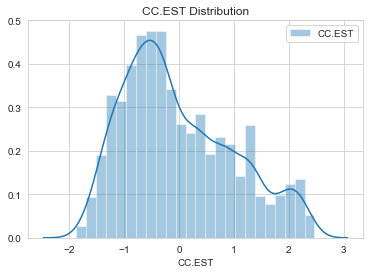

Shapiro-Wilk Test Statistics=0.954, p=0.000
Sample does not look Gaussian (reject H0)


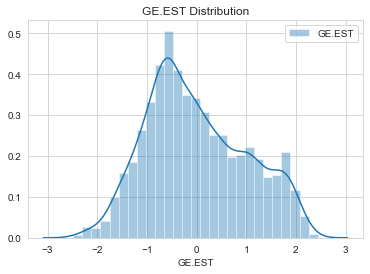

Shapiro-Wilk Test Statistics=0.975, p=0.000
Sample does not look Gaussian (reject H0)


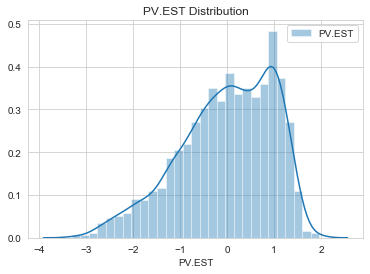

Shapiro-Wilk Test Statistics=0.963, p=0.000
Sample does not look Gaussian (reject H0)


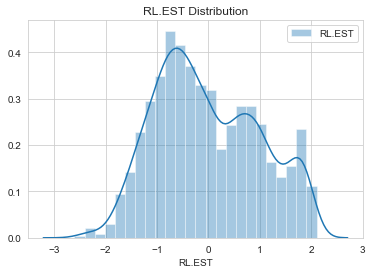

Shapiro-Wilk Test Statistics=0.973, p=0.000
Sample does not look Gaussian (reject H0)


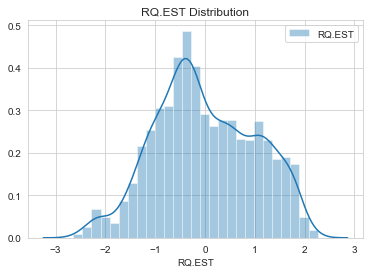

Shapiro-Wilk Test Statistics=0.985, p=0.000
Sample does not look Gaussian (reject H0)


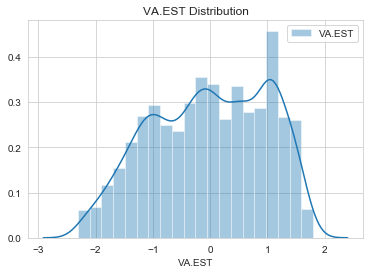

Shapiro-Wilk Test Statistics=0.968, p=0.000
Sample does not look Gaussian (reject H0)


In [84]:
from scipy.stats import shapiro
import helper_functions
cont_cols = list(pivot_gov.columns[2:])
plot_histkde(pivot_gov.dropna(), cont_cols)